# Optimization of an agent in Flappy Bird game using Genetic Algorithm

In this project we will develop an agent that plays Flappy Bird using Neural Networks and Genetic Algorithm

# Basic Imports

In [116]:
import pygame
import random
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Constants

In [117]:
SCREEN_WIDTH = 400
SCREEN_HEIGHT = 600
PIPE_SPEED = 4   # How many pixels the pipe moves to the left each frame
GRAVITY = 0.5    # How much the bird's vertical speed increases downward in each frame
BIRD_JUMP = -8
POPULATION_SIZE = 100  # How many birds (agents) do we test simultaneously in one round (generation)
MUTATION_RATE = 0.2   # Strength of "gene"(weights) change. If it is 0.2, we change the weights by approximately 20%.
MUTATION_STRENGTH = 0.05

# Neural Network

Inputs(6) : y bird position(relative to the centre of the gap), y top pipe, y lower pipe, horizontal distance, bird velocity, gap size

Hidden layer : 16 nodes

Output layer : 1 node

In [118]:
class BirdBrain(nn.Module):
    def __init__(self):
        super(BirdBrain, self).__init__()

        self.fc = nn.Sequential(
            nn.Linear(6, 16),  #6 inputs, hidden layer has 18 nodes
            nn.ReLU(),  #activation, if the signal is negative, set it to zero
            nn.Linear(16, 1),  #from hidden layer to output layer that determines wether the bird should jump
            nn.Sigmoid(),    #if output is >0.5, JUMP
        )

        for param in self.parameters():  # turning off "gradient learning"
            param.requires_grad = False

    def forward(self, x):
        return self.fc(x)

# Game Logic

**Agent**:

In [119]:
class Bird:
    def __init__(self):
        self.y = SCREEN_HEIGHT // 2    #y position of the bird
        #normalized (0-1) relative to the screen height


        self.vel = 0
        self.brain = BirdBrain()

        #the longer the bird is alive in the game, the better the fitness
        #GA will use this number to see who is the 'winner'
        #crucial for evolution
        self.fitness = 0 

        self.alive = True 
        self.score = 0

    def jump(self):
        self.vel = BIRD_JUMP

    def update(self, pipe_info):
        '''
            The bird looks at the pipe_info, sends the information to the brain.
            gets an answer (0-1) and decides whether it should jump
        '''

        if not self.alive : return


        '''
            We dont increment fitness for passing through the pipes.
            Because at the beginning all the birds would have 0 points (because none of them know how to pass the pipe). 
            In this way, the one who "survived" longer, even if only by falling, gets a slightly higher grade, which directs the evolution.
        '''
        self.fitness += 0.1 #reward for surviving the frame

        self.vel += GRAVITY # in each frame we add the gravity to the velocity and the velocity to the position
        self.y += self.vel  # this creates a realistic feeling of "falling"

        pipe_center = (pipe_info['top'] + pipe_info['bottom']) / 2

        # DECISION PROCESS - AI
        inputs = torch.tensor(
            [
                (self.y - pipe_center) / SCREEN_HEIGHT,
                pipe_info['top'] / SCREEN_HEIGHT,
                pipe_info['bottom'] / SCREEN_HEIGHT,
                pipe_info['dist'] / SCREEN_WIDTH,
                self.vel / 15,
                pipe_info['gap'] / 200
            ],
            dtype=torch.float32
        )   # normalization (0-1)


        # check if the bird should jump
        if self.brain(inputs).item() > 0.5:
            self.jump()


        # check for collision
        if self.y < 0 or self.y > SCREEN_HEIGHT:
            self.fitness -= 10 #punishment
            self.alive = False



In [120]:
class Pipe:
    def __init__(self, x):
        self.x =x
        self.gap = random.randint(120, 180)
        self.top = random.randint(50, SCREEN_HEIGHT - self.gap - 50)
        self.bottom = self.top + self.gap
        self.passed = False
    
    def update(self):
        self.x -= PIPE_SPEED

# Genetic Algorithm

In [121]:
def mutate(brain):
    for param in brain.parameters():
        # Pravimo masku koja određuje koji će se delovi težina menjati
        mask = torch.rand_like(param) < MUTATION_RATE
        # Pravimo nasumični šum snage MUTATION_STRENGTH
        noise = torch.randn_like(param) * MUTATION_STRENGTH
        # Dodajemo šum samo tamo gde je maska True
        param.data += mask * noise

In [122]:
def crossover(parent1, parent2, child):
    for p1, p2, c in zip(parent1.parameters(), parent2.parameters(), child.parameters()):
        mask = torch.rand_like(p1) > 0.5          #  create a random map of zeros and ones (50/50 chance)
        c.data = torch.where(mask, p1.data, p2.data) 
        # Where the mask is 1, take the gene from parent 1; where 0 is, take it from parent 2. The result goes to the child

# Game Loop

Gen 1 | Best Fitness: 12 | Avg Fitness: -5 | Max Score: 0
Gen 2 | Best Fitness: 13 | Avg Fitness: -3 | Max Score: 0
Gen 3 | Best Fitness: 46 | Avg Fitness: 0 | Max Score: 0
Gen 4 | Best Fitness: 31 | Avg Fitness: 3 | Max Score: 0
Gen 5 | Best Fitness: 121 | Avg Fitness: 12 | Max Score: 0
Gen 6 | Best Fitness: 118 | Avg Fitness: 14 | Max Score: 0
Gen 7 | Best Fitness: 57 | Avg Fitness: 15 | Max Score: 0
Gen 8 | Best Fitness: 68 | Avg Fitness: 13 | Max Score: 0
Gen 9 | Best Fitness: 245 | Avg Fitness: 29 | Max Score: 0
Gen 10 | Best Fitness: 461 | Avg Fitness: 56 | Max Score: 0
Gen 11 | Best Fitness: 189 | Avg Fitness: 48 | Max Score: 0
Gen 12 | Best Fitness: 170 | Avg Fitness: 31 | Max Score: 0
Gen 13 | Best Fitness: 259 | Avg Fitness: 21 | Max Score: 0
Gen 14 | Best Fitness: 153 | Avg Fitness: 24 | Max Score: 0
Gen 15 | Best Fitness: 860 | Avg Fitness: 49 | Max Score: 0
Gen 16 | Best Fitness: 381 | Avg Fitness: 57 | Max Score: 0
Gen 17 | Best Fitness: 956 | Avg Fitness: 62 | Max Score:

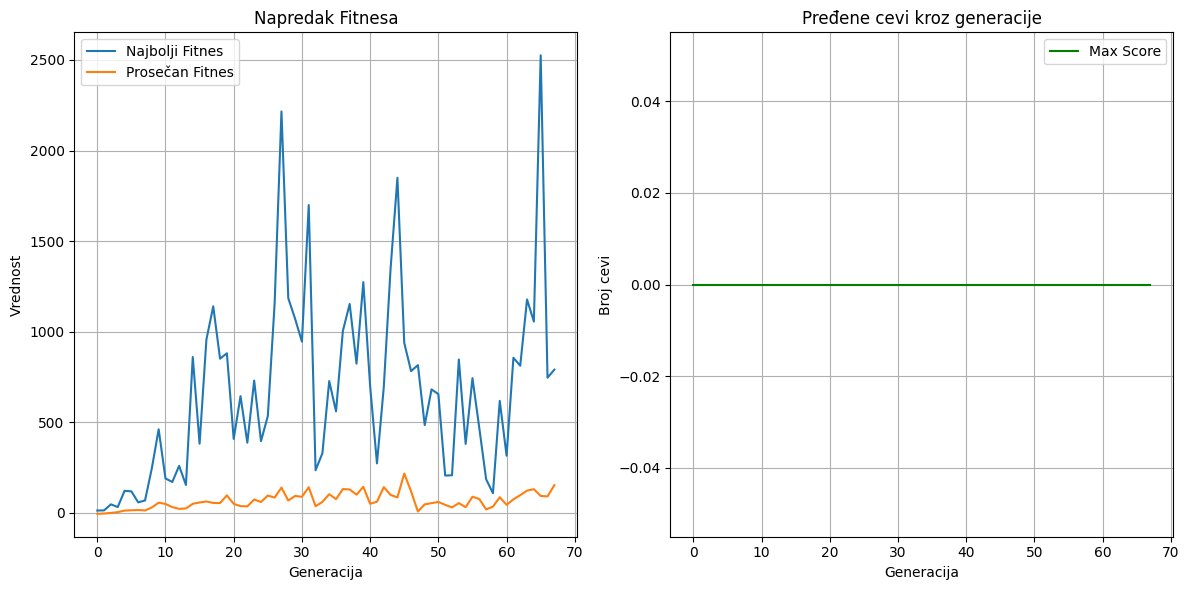

In [123]:
def main():
    pygame.init()
    screen = pygame.display.set_mode((SCREEN_WIDTH, SCREEN_HEIGHT))
    clock = pygame.time.Clock()
    font = pygame.font.SysFont("Arial", 24)

    population = [Bird() for _ in range(POPULATION_SIZE)]
    generation = 1
    best_fitness_history = []  # Ovde skupljamo podatke
    avg_fitness_history = []
    max_score_history = []  # Pratimo broj rupa

    running_program = True # Kontrola glavne petlje

    while running_program: 
        # Prva cev se stvara na 400px udaljenosti, a ne nasumično blizu
        # Razmak između cevi ostaje nasumičan za kasnije, 
        # ali prva ptica ima vremena da se stabilizuje
        pipes = [Pipe(SCREEN_WIDTH + 400)]
        
        next_pipe_dist = random.randint(200, 350)
        running_generation = True

        while running_generation:
            screen.fill((135, 206, 235))

            # --- Input/Event handling ---
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    running_program = False
                    running_generation = False # Prekidamo sve

            # --- Logika cevi ---
            if pipes[-1].x < SCREEN_WIDTH - next_pipe_dist:
                pipes.append(Pipe(SCREEN_WIDTH))
                next_pipe_dist = random.randint(200, 350)

            if pipes[0].x < -50:
                pipes.pop(0)

            target_pipe = pipes[0]
            if target_pipe.x + 50 < 50: 
                target_pipe = pipes[1]

            pipe_info = {
                'top': target_pipe.top, 
                'bottom': target_pipe.bottom, 
                'dist': target_pipe.x, 
                'gap': target_pipe.gap
            }

            # --- Update ptica ---
            all_dead = True
            for bird in population:
                if bird.alive:
                    all_dead = False
                    bird.update(pipe_info)

                    # Nagrada za prolazak
                    if not target_pipe.passed and (target_pipe.x + 50) < 50:
                        bird.fitness += 500
                        bird.score += 1

                    # Kolizija
                    if target_pipe.x < 100 and target_pipe.x + 50 > 50:
                        if bird.y < target_pipe.top or bird.y > target_pipe.bottom:
                            bird.fitness -= 5
                            bird.alive = False
                    
                    pygame.draw.circle(screen, (255, 255, 0), (50, int(bird.y)), 15)

            if not target_pipe.passed and (target_pipe.x + 50) < 50:
                target_pipe.passed = True

            if all_dead:
                running_generation = False

            # --- Crtanje cevi ---
            for pipe in pipes:
                pipe.update()
                pygame.draw.rect(screen, (0, 255, 0), (pipe.x, 0, 50, pipe.top))
                pygame.draw.rect(screen, (0, 255, 0), (pipe.x, pipe.bottom, 50, SCREEN_HEIGHT))

            # UI
            img = font.render(f"Gen: {generation}  Alive: {sum(b.alive for b in population)}", True, (0,0,0))
            screen.blit(img, (10, 10))

            pygame.display.flip()
            clock.tick(0)

        # --- KRAJ GENERACIJE: Evolucija ---
        if not running_program: break # Ako je ugašen prozor, ne radi evoluciju


        # --- STATISTIKA NAKON GENERACIJE ---
        population.sort(key=lambda x: x.fitness, reverse=True)
        
        # 1. Najbolji fitnes
        best_f = population[0].fitness
        # 2. Prosečan fitnes
        avg_f = sum(b.fitness for b in population) / len(population)
        # 3. Najbolji score (broj rupa)
        best_s = max(b.score for b in population)

        best_fitness_history.append(best_f)
        avg_fitness_history.append(avg_f)
        max_score_history.append(best_s)

        print(f"Gen {generation} | Best Fitness: {int(best_f)} | Avg Fitness: {int(avg_f)} | Max Score: {best_s}")

        # --- KRITERIJUM ZAUSTAVLJANJA (100 CEVI) ---
        if best_s >= 100:
            print(f"POBEDA! Agent je prošao 100 cevi u {generation}. generaciji.")
            running_program = False

        
        # 3. Selekcija roditelja i elitizam
        best_birds = population[:5]
        new_population = []
        for i in range(2):
            elite = Bird()
            elite.brain.load_state_dict(best_birds[i].brain.state_dict())
            new_population.append(elite)
            
        # 4. Kreiranje nove dece
        while len(new_population) < POPULATION_SIZE:
            p1, p2 = random.sample(best_birds, 2)
            child = Bird()
            crossover(p1.brain, p2.brain, child.brain)
            mutate(child.brain)
            new_population.append(child)
            
        population = new_population
        generation += 1

    # --- KRAJ PROGRAMA: Prikaz grafikona (Van glavne petlje!) ---
    pygame.quit()
    
   # --- FINALNO TESTIRANJE I PRIKAZ PERFORMANSI ---
    plt.figure(figsize=(12, 6))

    # Grafikon 1: Fitness (Best vs Avg)
    plt.subplot(1, 2, 1) # Jedan red, dve kolone, prvi grafik
    plt.plot(best_fitness_history, label="Najbolji Fitnes")
    plt.plot(avg_fitness_history, label="Prosečan Fitnes")
    plt.title("Napredak Fitnesa")
    plt.xlabel("Generacija")
    plt.ylabel("Vrednost")
    plt.legend()
    plt.grid(True)

    # Grafikon 2: Broj pređenih rupa
    plt.subplot(1, 2, 2) # Jedan red, dve kolone, drugi grafik
    plt.plot(max_score_history, color='green', label="Max Score")
    plt.title("Pređene cevi kroz generacije")
    plt.xlabel("Generacija")
    plt.ylabel("Broj cevi")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()
